## <font color="Greenyellow">Trabajo de Fin Master 3: Optimizacion de hiperparametros</font>
<a id="item0"></a> 

### <font color="Greenyellow">0. Indice</font>

* [1. Inicializacion del notebook](#item1)
* [2. ETL](#item2)
* [3. Modelos base](#item3)


***
<a id="item1"></a>
### <font color="Greenyellow">1. Inicializacion del notebook</font>

#### <font color="Greenyellow">1.1. Importacion de librerias</font>

In [1]:
# Analisis y transformacion de datos
import pandas as pd
import numpy as np
# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# Base de datos
import sqlite3
# Funciones propias en carpeta 'funciones
import funciones.funciones as funciones
# funciones machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import fbeta_score
# Optimizadores
from skopt import BayesSearchCV
from skopt.space import Real, Integer
# Modelos
import joblib

#### <font color="Greenyellow">1.2. Parametros del notebook</font>

In [2]:
carpeta_base_datos = 'bbdd'
nombre_bbdd        = 'base_datos_tfm.db'
semilla = 12345
pct_test=0.20

***
<a id="item2"></a>
### <font color="Greenyellow">2. ETL</font>
[Volver al indice](#item0)

In [3]:
# importamos los datos
df = funciones.query_bbdd(carpeta_base_datos, nombre_bbdd='base_datos_tfm.db', query='SELECT * FROM meta_df')

In [4]:
# transformamos los datos y dividimos en train y test
X_train, X_test, y_train, y_test = funciones.preparar_datos(df, n_columnas_x=31, pct_test=pct_test, semilla=semilla)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (227845, 31), y_train shape: (227845,)
X_test shape: (56962, 31), y_test shape: (56962,)


***
<a id="item3"></a>
### <font color="Greenyellow">3. Random Forest</font>
[Volver al indice](#item0)

#### <font color="Greenyellow">3.1. Modelo sin optimizar</font>

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8916
    C. AUC: 0.9273
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8222
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.97      0.82      0.89        90

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



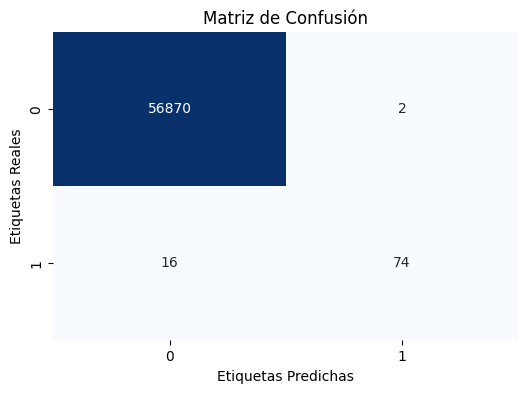


   Puntuaciones F1 de CV (k=5): [0.80272109 0.8630137  0.83333333 0.84137931 0.90666667]
   Promedio de F1 de CV: 0.8494


In [5]:
# 1. Instanciamos el modelo
model = RandomForestClassifier(n_estimators=20, random_state=semilla, n_jobs=-1)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

#### <font color="Greenyellow">3.2. Optimizacion de hiperparametros</font>

In [6]:
# Instanciamos el modelo a optimizar
model = RandomForestClassifier(random_state=semilla, n_jobs=-1)

In [7]:
%%time
# Define el espacio de búsqueda
espacio_busqueda = {
    "n_estimators": Integer(20, 50),
    "max_features": Real(0.3, 0.7, prior='uniform'),
    "max_depth": Integer(5, 15),
    "min_samples_split": Integer(2, 10),
}   
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=semilla)
# Búsqueda Bayesiana
opt = BayesSearchCV(
    estimator=model,
    search_spaces=espacio_busqueda,
    scoring="average_precision",
    cv=cv,  
    n_iter=20,
    n_jobs=-1,
    verbose=0,
    random_state=semilla
)

# Entrenamiento del optimizador
opt.fit(X_train, y_train)

# Mejor resultado
print("Mejores parámetros encontrados:")
print(opt.best_params_)
print(f"Mejor puntuación average_precision (AUC-PR): {opt.best_score_:.4f}")

Mejores parámetros encontrados:
OrderedDict([('max_depth', 15), ('max_features', 0.3850560451339345), ('min_samples_split', 2), ('n_estimators', 26)])
Mejor puntuación average_precision (AUC-PR): 0.8344
CPU times: total: 2min 58s
Wall time: 5min 25s


In [8]:
# Guardamos los mejores parametros con joblib
joblib.dump(opt.best_params_, 'data/parametros/r_forest_best_params.pkl')

['data/parametros/r_forest_best_params.pkl']

#### <font color="Greenyellow">3.3. Modelo optimizado</font>

In [9]:
# Cargamos los mejores parametros
best_params_rf = ""
best_params_rf = joblib.load('data/parametros/r_forest_best_params.pkl')
best_params_rf

OrderedDict([('max_depth', 15),
             ('max_features', 0.3850560451339345),
             ('min_samples_split', 2),
             ('n_estimators', 26)])

1. Entrenando el modelo...
... entrenamiento completado.
    A. Precisión del modelo: 0.9997
    B. F1 Score: 0.8848
    C. AUC: 0.9781
    D. Recall (Sensibilidad) Clase Minoritaria (1): 0.8111
    E. Metricas desagregadas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.97      0.81      0.88        90

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



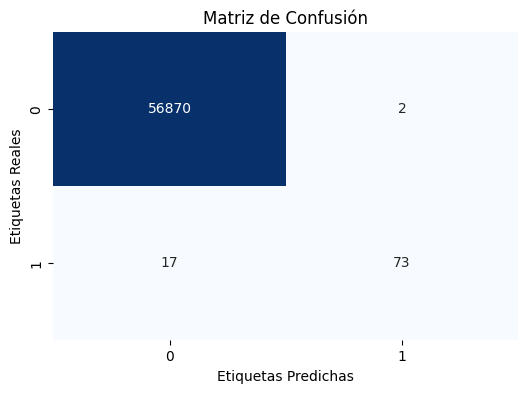


   Puntuaciones F1 de CV (k=5): [0.82191781 0.8707483  0.82269504 0.85714286 0.91390728]
   Promedio de F1 de CV: 0.8573


In [10]:
# 1. Instanciamos el modelo
model = RandomForestClassifier(**best_params_rf, random_state=semilla, n_jobs=-1)
# 2. Implementamos validación cruzada (CV) al modelo (5 pliegues)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
# 3. Entrenamos el modelo
print("1. Entrenando el modelo...")
model.fit(X_train, y_train)
print("... entrenamiento completado.")
# 4. Evaluamos el modelo
accuracy, f1, auc, recall_minoritaria, metricas_desagregadas, c_matrix = funciones.evaluar_modelo(model, X_test, y_test)
print(f"\n   Puntuaciones F1 de CV (k=5): {cv_scores}")
print(f"   Promedio de F1 de CV: {np.mean(cv_scores):.4f}")

In [11]:
f2_rand_forest = fbeta_score(y_test, model.predict(X_test), beta=2, pos_label=1)
print(f'F2 score LightGBM: {f2_rand_forest:.4f}')

F2 score LightGBM: 0.8391


In [12]:
# guardamos el f1 y recall en la carpeta de data mediante joblib
joblib.dump(f1, 'data/metricas/f1_rand_forest.pkl')
joblib.dump(recall_minoritaria, 'data/metricas/recall_rand_forest.pkl')
joblib.dump(f2_rand_forest, 'data/metricas/f2_rand_forest.pkl')

['data/metricas/f2_rand_forest.pkl']

***
[Volver al indice](#item0)